In [1]:
import os
import pandas as pd
import requests
from zipfile import ZipFile
from typing import List, Dict, Union
from pydantic import BaseModel
from distances import haversine_distance, Coordinates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import Markdown, display
import seaborn as sns
#from pandasai import SmartDataframe
from ast import literal_eval

In [2]:
import pandas as pd
airlines_df = pd.read_csv('C:/Users/irene/OneDrive/Desktop/NOVA/S2T1/Adpro/flight_data/airlines.csv')
airplanes_df = pd.read_csv('C:/Users/irene/OneDrive/Desktop/NOVA/S2T1/Adpro/flight_data/airplanes.csv')
airports_df = pd.read_csv('C:/Users/irene/OneDrive/Desktop/NOVA/S2T1/Adpro/flight_data/airports.csv')
routes_df =  pd.read_csv('C:/Users/irene/OneDrive/Desktop/NOVA/S2T1/Adpro/flight_data/routes.csv')

In [17]:
def departing_flights_airport(airport, internal=False):
        """
        Retrieve and display information about departing flights from a given airport.

        Args:
            airport (str): The IATA code of the airport for which departing flights will be retrieved.
            internal (bool, optional): If True, only internal flights (destination in the same country) will be displayed. Defaults to False.

        Returns:
            None

        This method retrieves information about departing flights from a specified airport and displays it.
        It joins the routes and airports DataFrames to obtain flight information.
        It filters flights based on the given airport and optionally on whether they are internal.
        If internal is True, only flights with the same source and destination country are displayed.
        If there are no departing flights or no internal flights, appropriate messages are printed.
        """
        def plot_all_routes_colors(df):
            
            fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

            # Add geographical features
            ax.add_feature(cfeature.LAND)
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS, linestyle=':')

                # Iterate over the rows in the DataFrame and plot each route
            for _, row in df.iterrows():
                source_lat = row['Source_lat']
                source_lon = row['Source_lon']
                dest_lat = row['Dest_lat']
                dest_lon = row['Dest_lon']

                # Set marker style for all flights
                marker_style = 'o' if row['Source Country'] == row['Destination Country'] else '^'

                # Using markers to denote airport points
                ax.plot([source_lon, dest_lon], [source_lat, dest_lat], linestyle='-', color='#41B6C4', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())
                ax.plot(source_lon, source_lat, marker_style, color= '#41B6C4', markersize=5, alpha=0.8, transform=ccrs.PlateCarree())
                ax.plot(dest_lon, dest_lat, marker_style, color='#41B6C4', markersize=5, alpha=0.8, transform=ccrs.PlateCarree())

            plt.title('All Flight Routes')
            plt.show()



        # Join on Source airport
        airport_info_1 = routes_df[['Source airport', 'Destination airport']].join(airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Source airport')
        # Rename the column
        airport_info_1.rename(columns={'Country': 'Source Country', 'Latitude':'Source_lat', 'Longitude': 'Source_lon'}, inplace=True)
        airport_info_1[["Source Country", "Source_lat", "Source_lon", "Source airport", "Destination airport"]]
        
        
        airport_info_2 = airport_info_1.join(airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Destination airport')
        # Rename the column if needed
        airport_info_2.rename(columns={'Country': 'Destination Country','Latitude':'Dest_lat', 'Longitude': 'Dest_lon'}, inplace=True)
        # Drop the additional index columns
        airport_info_2 = airport_info_2.reset_index(drop=True)
        
        # Filter flights based on the given source country
        source_flights = airport_info_2[airport_info_2['Source airport'] == airport]
        source_flights = source_flights[~source_flights.duplicated()]

        del airport_info_1, airport_info_2
        
        # We only want to count each route 1 time - let's deal with this
        # Create a new column 'Route' that represents the route in a direction-agnostic way
        source_flights['Route'] = source_flights.apply(lambda x: '-'.join(sorted([x['Source airport'], x['Destination airport']])), axis=1)

        # Drop duplicates based on the 'Route' column
        source_flights = source_flights.drop_duplicates(subset=['Route'])

        # Drop the 'Route' column if you don't need it anymore
        source_flights = source_flights.drop('Route', axis=1)

        # Get coordinates for source and destination airports
        if internal:
            # Filter for internal flights (destination in the same country)
            source_flights = source_flights[source_flights['Source Country'] == source_flights['Destination Country']]

        # Check if there are any flights to display
        if not source_flights.empty:
            if internal:
                print(f"Internal flights from {airport} to destinations in the same country:")
            else:
                print(f"All flights from {airport}:")

            plot_all_routes_colors(source_flights)

        else:
                print(f"No internal flights.")


All flights from JFK:


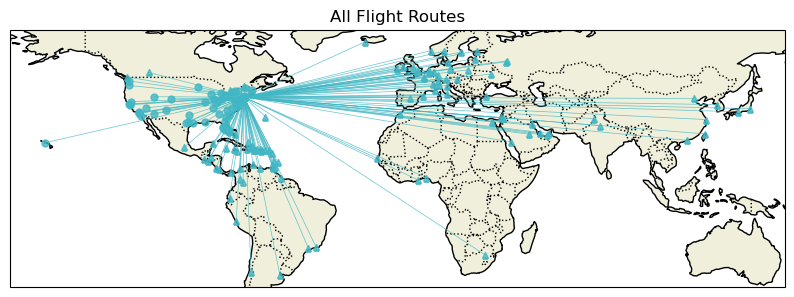

In [18]:
departing_flights_airport('JFK')

Data files already exist in the downloads directory.
All flights from JFK:


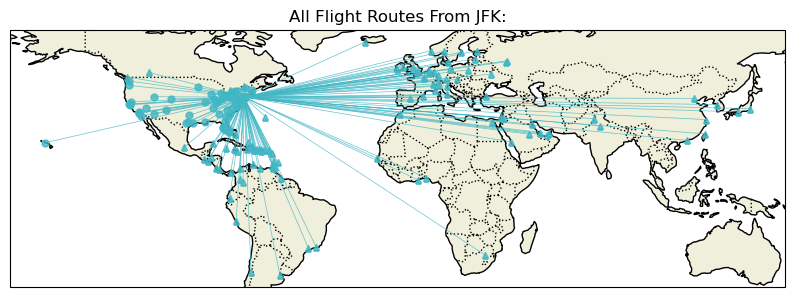

In [22]:
class FlightData:

    def __init__(self):
        self.download_dir = "./downloads"
        self.data_url = "https://gitlab.com/adpro1/adpro2024/-/raw/main/Files/flight_data.zip"
        self.data_files = {
            "airplanes": "airplanes.csv",
            "airports": "airports.csv",
            "airlines": "airlines.csv",
            "routes": "routes.csv"
        }
        self.airplanes_df = None
        self.airports_df = None
        self.airlines_df = None
        self.routes_df = None
        self.list_of_models = None

        # Create the downloads directory if it doesn't exist
        if not os.path.exists(self.download_dir):
            os.makedirs(self.download_dir)

        # Check if all data files exist in the downloads directory
        files_exist = all(os.path.exists(os.path.join(self.download_dir, file)) for file in self.data_files.values())

        if not files_exist:
            zip_file_path = os.path.join(self.download_dir, "flight_data.zip")
            if not os.path.exists(zip_file_path):
                url = self.data_url
                response = requests.get(url)
                if response.status_code == 200:
                    with open(zip_file_path, "wb") as file:
                        file.write(response.content)
                    with ZipFile(zip_file_path, 'r') as zip_ref:
                        zip_ref.extractall(self.download_dir)
                    os.remove(zip_file_path)
                    print("Data downloaded and extracted successfully.")
                else:
                    print("Failed to download data.")
            else:
                print("Data already exists.")
        else:
            print("Data files already exist in the downloads directory.")

        # Load the data files into DataFrames
        if os.path.exists(self.download_dir):
            self.airplanes_df = pd.read_csv(os.path.join(self.download_dir, self.data_files["airplanes"]), index_col=0)
            self.airports_df = pd.read_csv(os.path.join(self.download_dir, self.data_files["airports"]), index_col=0)
            self.airlines_df = pd.read_csv(os.path.join(self.download_dir, self.data_files["airlines"]), index_col=0)
            self.routes_df = pd.read_csv(os.path.join(self.download_dir, self.data_files["routes"]), index_col=0)
        else:
            print("Data directory does not exist. Please download the data first.")


    def departing_flights_airport(self, airport, internal=False):
        """
        Retrieve and display information about flights from a given airport.

        Args:
            airport (str): The IATA code of the airport for which departing flights will be retrieved.
            internal (bool, optional): If True, only internal flights (destination in the same country) will be displayed. Defaults to False.

        Returns:
            Plot showing all flight routes from the specified airport.

        This method retrieves information about departing flights from a specified airport and displays it.
        It joins the routes and airports DataFrames to obtain flight information.
        It filters flights based on the given airport and optionally on whether they are internal.
        If internal is True, only flights with the same source and destination country are displayed.
        If there are no departing flights or no internal flights, appropriate messages are printed.
        """
        def plot_all_routes_colors(df):
            '''
            This function plots all flight routes from a given airport on a map.
            
            
            Args:
                df (DataFrame): DataFrame containing flight route information.

            Returns:
                Plot showing all flight routes from the specified airport.
            '''
            fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

            # Add geographical features
            ax.add_feature(cfeature.LAND)
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS, linestyle=':')

                # Iterate over the rows in the DataFrame and plot each route
            for _, row in df.iterrows():
                source_lat = row['Source_lat']
                source_lon = row['Source_lon']
                dest_lat = row['Dest_lat']
                dest_lon = row['Dest_lon']

                # Set marker style for all flights
                marker_style = 'o' if row['Source Country'] == row['Destination Country'] else '^'

                # Using markers to denote airport points
                ax.plot([source_lon, dest_lon], [source_lat, dest_lat], linestyle='-', color='#41B6C4', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())
                ax.plot(source_lon, source_lat, marker_style, color= '#41B6C4', markersize=5, alpha=0.8, transform=ccrs.PlateCarree())
                ax.plot(dest_lon, dest_lat, marker_style, color='#41B6C4', markersize=5, alpha=0.8, transform=ccrs.PlateCarree())

            plt.title(f'All Flight Routes From {airport}:')
            plt.show()



        # Join on Source airport
        airport_info_1 = self.routes_df[['Source airport', 'Destination airport']].join(self.airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Source airport')
        # Rename the column
        airport_info_1.rename(columns={'Country': 'Source Country', 'Latitude':'Source_lat', 'Longitude': 'Source_lon'}, inplace=True)
        airport_info_1[["Source Country", "Source_lat", "Source_lon", "Source airport", "Destination airport"]]
        
        
        airport_info_2 = airport_info_1.join(self.airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Destination airport')
        # Rename the column if needed
        airport_info_2.rename(columns={'Country': 'Destination Country','Latitude':'Dest_lat', 'Longitude': 'Dest_lon'}, inplace=True)
        # Drop the additional index columns
        airport_info_2 = airport_info_2.reset_index(drop=True)
        
        # Filter flights based on the given source country
        source_flights = airport_info_2[airport_info_2['Source airport'] == airport]
        source_flights = source_flights[~source_flights.duplicated()]

        del airport_info_1, airport_info_2
        
        # We only want to count each route 1 time - let's deal with this
        # Create a new column 'Route' that represents the route in a direction-agnostic way
        source_flights['Route'] = source_flights.apply(lambda x: '-'.join(sorted([x['Source airport'], x['Destination airport']])), axis=1)

        # Drop duplicates based on the 'Route' column
        source_flights = source_flights.drop_duplicates(subset=['Route'])

        # Drop the 'Route' column if you don't need it anymore
        source_flights = source_flights.drop('Route', axis=1)

        # Get coordinates for source and destination airports
        if internal:
            # Filter for internal flights (destination in the same country)
            source_flights = source_flights[source_flights['Source Country'] == source_flights['Destination Country']]

        # Check if there are any flights to display
        if not source_flights.empty:
            if internal:
                print(f"Internal flights from {airport} to destinations in the same country:")
            else:
                print(f"All flights from {airport}:")

            plot_all_routes_colors(source_flights)

        else:
                print(f"No internal flights.")


        
#print the aircrafts method of the class FlightData
flight_data = FlightData()
flight_data.departing_flights_airport('JFK')